In [1]:
import pandas as pd

In [2]:
%%time

national_names_df = pd.read_csv('./../data/NationalNames.csv', index_col=0)
state_names_df = pd.read_csv('./../data/StateNames.csv', index_col=0)

CPU times: user 4.86 s, sys: 564 ms, total: 5.43 s
Wall time: 5.45 s


In [55]:
yearly_female_state_names_df = state_names_df.loc[( 
                                                    (state_names_df['Year']==2000)
                                                   & (state_names_df['Gender']=='F')
                                                  )].drop(
                                                    ['Year', 'Gender'], 
                                                        axis=1).pivot_table(
                                                                    index='State', 
                                                                    values='Count', 
                                                                    columns='Name')


def f(row):
    return ( row.argmax(), row.max() )
    
_yearly_top_names_s = yearly_female_state_names_df.apply(f, axis=1)
yearly_top_names_df = pd.DataFrame([_yearly_top_names_s.apply(lambda x: x[0]), _yearly_top_names_s.apply(lambda x: x[1])]).T
yearly_top_names_df.columns = ['Name', 'Count']

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
df = yearly_top_names_df

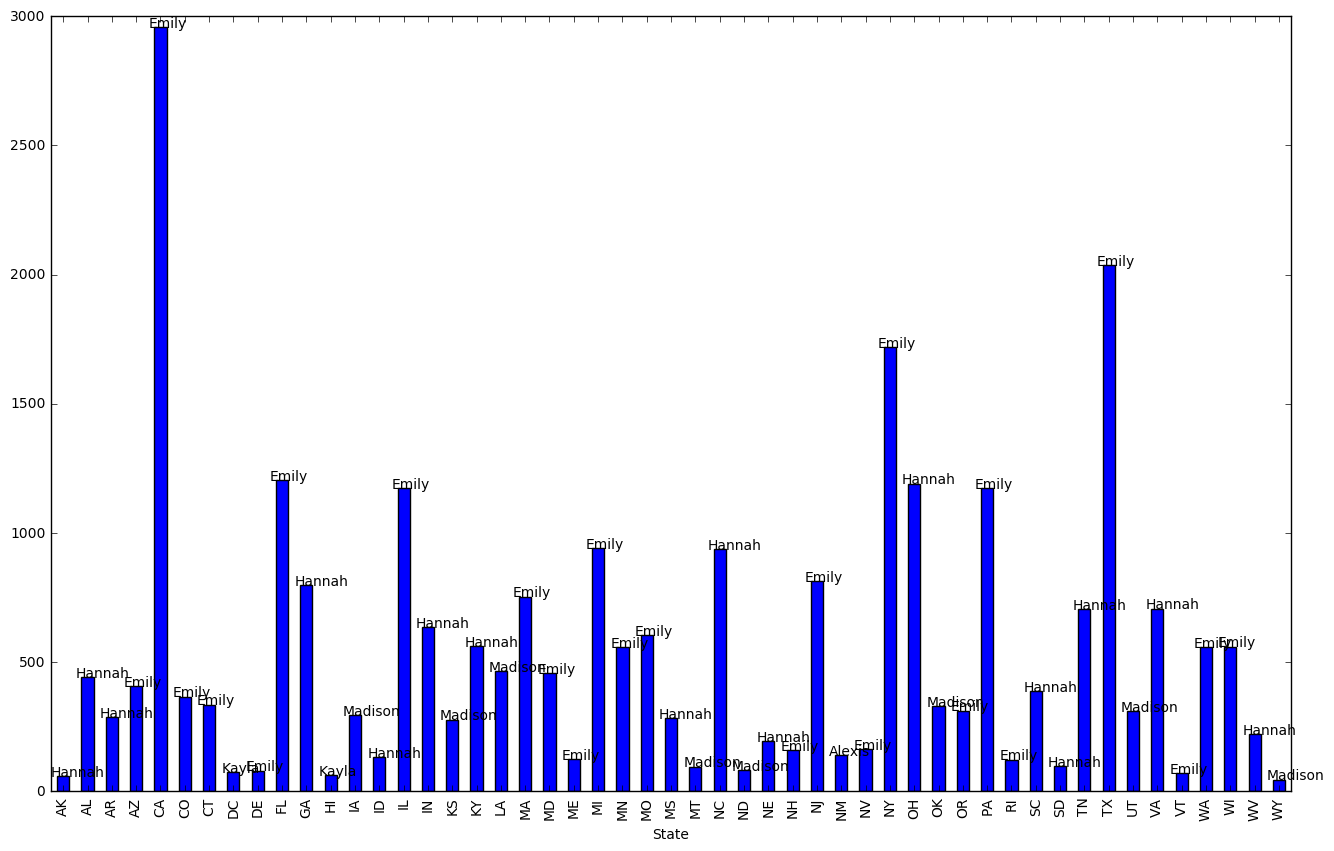

In [58]:

fig, axs = plt.subplots(1, 1, figsize=(16, 10))
ax = axs
yearly_top_names_df['Count'].plot.bar(ax=ax)
for i, (state, row) in enumerate(df.iterrows()):
    ax.text(i-0.5, row['Count'], row['Name'])

In [59]:
import geopandas as gpd

In [60]:
import numpy as np

def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return geometry.coords.xy[0]
    elif coord_type == 'y':
        return geometry.coords.xy[1]

def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry.exterior
    return getXYCoords(ext, coord_type)
    
def getLineCoords(geometry, coord_type):
    """ Returns Coordinates of Linestring object."""
    return getXYCoords(geometry, coord_type)

def getPointCoords(geometry, coord_type):
    """ Returns Coordinates of Point object."""
    if coord_type == 'x':
        return geometry.x
    elif coord_type == 'y':
        return geometry.y
    
def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """ 
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon. 
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list. 
    Individual geometries are separated with np.nan which is how Bokeh wants them. 
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """
    
    for i, part in enumerate(multi_geometry):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            if geom_type == "MultiPoint":
                coord_arrays = np.append(getPointCoords(part, coord_type), np.nan)
            elif geom_type == "MultiLineString":
                coord_arrays = np.append(getLineCoords(part, coord_type), np.nan)
            elif geom_type == "MultiPolygon":
                coord_arrays = np.append(getPolyCoords(part, coord_type), np.nan)
        else:
            if geom_type == "MultiPoint":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPointCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiLineString":
                coord_arrays = np.concatenate([coord_arrays, np.append(getLineCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiPolygon":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPolyCoords(part, coord_type), np.nan)])
    
    # Return the coordinates 
    return coord_arrays
    

def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) as a list (if geometry is LineString or Polygon). 
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]
    
    # Check the geometry type
    gtype = geom.geom_type
    
    # "Normal" geometries
    # -------------------
    
    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "LineString":
        return list( getLineCoords(geom, coord_type) )
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )
        
    # Multi geometries
    # ----------------
    
    else:
        return list( multiGeomHandler(geom, coord_type, gtype) ) 
    


In [61]:
data = gpd.read_file('../data/states_21basic/states.shp')

In [62]:
data = data.to_crs(crs=data.crs)

In [63]:
data['x'] = data.apply(getCoords, geom_col="geometry", coord_type="x", axis=1)
data['y'] = data.apply(getCoords, geom_col="geometry", coord_type="y", axis=1)

In [64]:
data = data.drop('geometry', axis=1)

In [66]:
from bokeh.io import show, output_notebook, push_notebook
output_notebook()

Loading BokehJS ...

In [89]:
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure

palette.reverse()

color_mapper = LogColorMapper(palette=palette)

# Select only necessary columns for our plotting to keep the amount of data minumum
plot_data = pd.merge(data, yearly_top_names_df, left_on='STATE_ABBR', right_index=True)
df = plot_data[['x', 'y', 'Count', 'Name', 'STATE_ABBR']]
dfsource = ColumnDataSource(data=df)

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(
    title="", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

patches = p.patches('x', 'y', 
          source=dfsource, name='Name',
          fill_color={'field': 'Count', 'transform': color_mapper}, 
          fill_alpha=0.7, line_color="white", line_width=0.5)


hover = HoverTool(renderers=[patches])
hover.tooltips=[("Count", "@Count"),
            ("Name", "@Name"),]

p.add_tools(hover)

h = show(p, notebook_handle=True)

In [91]:
interact(update, slider=widgets.IntSlider(min=sorted(list(state_names_df['Year'].unique()))[0], 
                                               max=sorted(list(state_names_df['Year'].unique()))[-1],
                                               step=1
                                              ),
        )

In [90]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def update(slider):
    yearly_female_state_names_df = state_names_df.loc[( 
                                                        (state_names_df['Year']==slider)
                                                       & (state_names_df['Gender']=='F')
                                                      )].drop(
                                                        ['Year', 'Gender'], 
                                                            axis=1).pivot_table(
                                                                        index='State', 
                                                                        values='Count', 
                                                                        columns='Name')


    def f(row):
        return ( row.argmax(), row.max() )

    _yearly_top_names_s = yearly_female_state_names_df.apply(f, axis=1)
    yearly_top_names_df = pd.DataFrame([_yearly_top_names_s.apply(lambda x: x[0]), _yearly_top_names_s.apply(lambda x: x[1])]).T
    yearly_top_names_df.columns = ['Name', 'Count']

    patches.data_source.data['Name'] = list(yearly_top_names_df.loc[patches.data_source.data['STATE_ABBR'], 'Name'])
    patches.data_source.data['Count'] = list(yearly_top_names_df.loc[patches.data_source.data['STATE_ABBR'], 'Count'])
    push_notebook()

In [82]:
df.sort_values('Count', ascending=False).head()

,x,y,Count,Name,STATE_ABBR
24,"[-121.66522031, -121.78236231, -121.90276631, ...","[38.169285363, 38.0667753629, 38.0729093629, 3...",3282,Emily,CA
40,"[-105.998886295, -106.213285295, -106.38358129...","[31.3939403567, 31.4782463568, 31.733872357, 3...",2480,Emily,TX
16,"[-79.7632352707, -79.4440202704, -79.354884270...","[42.2673273668, 42.419361367, 42.493461367, 42...",1444,Emily,NY
48,"[-80.7856622716, -80.7624152716, -80.832104271...","[28.7851943543, 28.7363343542, 28.7861863543, ...",1298,Emily,FL
25,"[-83.2727552739, -83.290043274, -83.306531274,...","[38.6092573634, 38.5966383634, 38.5963173634, ...",1056,Emma,OH
